In [3]:
import numpy as np
from deap import base, creator, tools, algorithms
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from bayes_opt import BayesianOptimization
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.operators.sampling.lhs import LHS
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
import plotly.graph_objects as go
from scipy.spatial.distance import euclidean

# Load and prepare the data
data = pd.read_csv('large.csv')  # Replace with your dataset path
pd.set_option('display.max_columns', None)
print(data.head())
# Define the inputs and outputs
X = data.drop(columns=['UCS', 'co2', 'cost'])
y_ucs = data['UCS']
y_co2 = data['co2']
y_cost = data['cost']

# Perform a single train-test split for all target variables
X_train, X_test, y_ucs_train, y_ucs_test, y_co2_train, y_co2_test, y_cost_train, y_cost_test = train_test_split(
    X, y_ucs, y_co2, y_cost, test_size=0.2, random_state=42
)
def optimize_xgb(X_train, y_train):
    def xgb_evaluate(n_estimators, learning_rate, max_depth, min_child_weight):
        model = XGBRegressor(
            n_estimators=int(n_estimators),
            learning_rate=learning_rate,
            max_depth=int(max_depth),
            min_child_weight=int(min_child_weight),
            random_state=42
        )
        r2_scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=5)
        return r2_scores.mean()

    pbounds = {
        'n_estimators': (100, 500),
        'learning_rate': (0.01, 0.3),
        'max_depth': (3, 10),
        'min_child_weight': (1, 10)
    }

    optimizer = BayesianOptimization(f=xgb_evaluate, pbounds=pbounds, random_state=42)
    optimizer.maximize(init_points=5, n_iter=25)
    
    return optimizer.max['params']
def train_and_evaluate_model(X_train, X_test, y_train, y_test, target_name):
    print(f"Optimizing {target_name} model...")
    best_params = optimize_xgb(X_train, y_train)
    model = XGBRegressor(
        n_estimators=int(best_params['n_estimators']),
        learning_rate=best_params['learning_rate'],
        max_depth=int(best_params['max_depth']),
        min_child_weight=int(best_params['min_child_weight']),
        random_state=42
    )
    model.fit(X_train, y_train)

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Evaluation Metrics
    print(f"{target_name} Model R² (Train):", r2_score(y_train, y_pred_train))
    print(f"{target_name} Model R² (Test):", r2_score(y_test, y_pred_test))
    print("=" * 50)

    return model  # Return the trained model

# Train and evaluate each target model and store them in variables
model_ucs = train_and_evaluate_model(X_train, X_test, y_ucs_train, y_ucs_test, 'UCS')
model_co2 = train_and_evaluate_model(X_train, X_test, y_co2_train, y_co2_test, 'CO₂')
model_cost = train_and_evaluate_model(X_train, X_test, y_cost_train, y_cost_test, 'Cost')




   FlyAsh  GGBFS    RM    SM    AM    HM    LM    CA   FA     SS    SH  SS/SH  \
0   476.0    0.0  0.54  1.43  2.44  0.01  0.72  1294  554  120.0  48.0    2.5   
1   476.0    0.0  0.54  1.43  2.44  0.01  0.72  1294  554  120.0  48.0    2.5   
2   476.0    0.0  0.54  1.43  2.44  0.01  0.72  1294  554  120.0  48.0    2.5   
3   476.0    0.0  0.54  1.43  2.44  0.01  0.72  1294  554  120.0  48.0    2.5   
4   476.0    0.0  0.54  1.43  2.44  0.01  0.72  1294  554  120.0  48.0    2.5   

   Mol_SH  SS_SiO2/Na2O  SH_Na2O %   SH_SiO2 %   SH_H2O %    WEff   W/B  \
0     8.0           2.0        14.7        29.4       55.9  99.72  0.35   
1     8.0           2.0        14.7        29.4       55.9  99.72  0.35   
2     8.0           2.0        14.7        29.4       55.9  99.72  0.35   
3     8.0           2.0        14.7        29.4       55.9  99.72  0.35   
4     8.0           2.0        14.7        29.4       55.9  99.72  0.35   

   Ti (hr.)  Cti (°C)  Cm  RH(%)  CTf(°C)  Age(Days)   cost   

gen	nevals
0  	100   
1  	183   
2  	176   
3  	182   
4  	180   
5  	177   
6  	178   
7  	178   
8  	180   
9  	184   
10 	182   
11 	177   
12 	179   
13 	184   
14 	172   
15 	178   
16 	184   
17 	172   
18 	183   
19 	177   
20 	172   
21 	181   
22 	180   
23 	183   
24 	181   
25 	175   
26 	182   
27 	183   
28 	183   
29 	174   
30 	181   
31 	182   
32 	177   
33 	175   
34 	181   
35 	174   
36 	185   
37 	171   
38 	187   
39 	186   
40 	183   
41 	180   
42 	181   
43 	177   
44 	174   
45 	177   
46 	184   
47 	179   
48 	173   
49 	179   
50 	181   


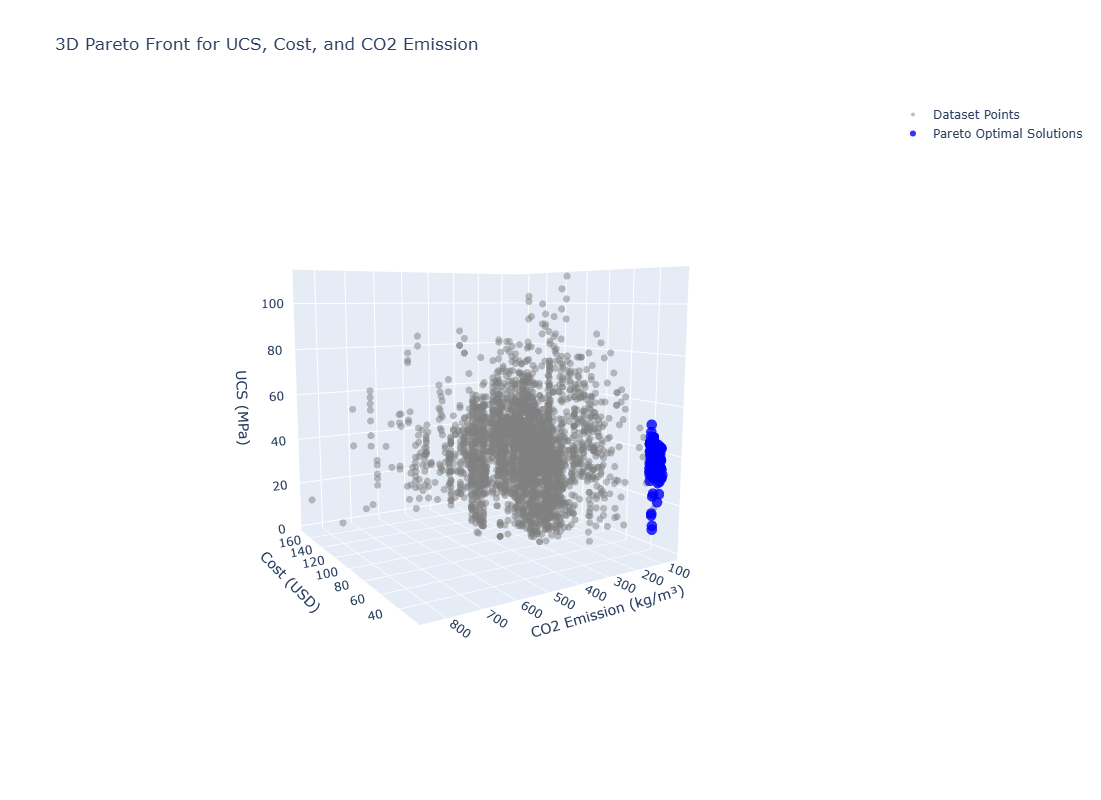

In [7]:
# Define NSGA-II objectives
def nsga2_objective(individual):
    X_input = np.array(individual).reshape(1, -1)
    ucs_pred = model_ucs.predict(X_input)[0]
    co2_pred = model_co2.predict(X_input)[0]
    cost_pred = model_cost.predict(X_input)[0]
    return cost_pred, co2_pred, -ucs_pred

# Set up DEAP for NSGA-II
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0, 1.0))  # cost, CO2 are minimized; UCS is maximized
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()

# Define the bounds of each input feature based on your dataset's range
BOUNDS = [
   (0, 1530),
   (0, 100),
   (0.4, 1),
   (1, 1.5),
   (2, 3),
   (0, 1),
   (0, 1),
   (1200, 1300),
   (500, 600),
   (100, 130),
   (0, 1500),
   (0, 100),
   (0, 100),
   (0, 1000),
   (0, 1000),
   (0, 1000),
   (0, 1000),
   (0, 1000),
   (0.3, 0.4),
   (0, 24),
   (20, 90),
   (0, 1),
   (30, 40),
   (20, 90),
   (0, 30),
]

# Define a random individual generator within the bounds
def random_individual():
    return [np.random.uniform(low, high) for low, high in BOUNDS]

toolbox.register("individual", tools.initIterate, creator.Individual, random_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", nsga2_objective)
toolbox.register("mate", tools.cxBlend, alpha=0.5)

def custom_mutation(individual, eta, low, up, indpb):
    for i, (xl, xu) in enumerate(zip(low, up)):
        if np.random.rand() < indpb:
            x = individual[i]
            delta1 = max(0, min((x - xl) / (xu - xl), 1))
            delta2 = max(0, min((xu - x) / (xu - xl), 1))
            rand = np.random.rand()
            mut_pow = 1.0 / (eta + 1.0)

            try:
                if rand <= 0.5:
                    delta_q = (2.0 * rand + (1.0 - 2.0 * rand) * (1.0 - delta1) ** (eta + 1.0)) ** mut_pow - 1.0
                else:
                    delta_q = 1.0 - (2.0 * (1.0 - rand) + 2.0 * (rand - 0.5) * (1.0 - delta2) ** (eta + 1.0)) ** mut_pow
                x += delta_q * (xu - xl)
                
                # Check if the result is complex and correct it
                if isinstance(x, complex):
                    x = x.real  # Only take the real part if complex

            except ValueError:
                # If any error occurs, skip mutation for this value
                x = individual[i]

            individual[i] = min(max(x, xl), xu)  # Ensure x remains within bounds

    return individual,


# Register the custom mutation function
toolbox.register("mutate", custom_mutation, eta=0.5, low=[b[0] for b in BOUNDS], up=[b[1] for b in BOUNDS], indpb=0.2)
toolbox.register("select", tools.selNSGA2)

# Run NSGA-II
def run_nsga2(pop_size=100, generations=50):
    population = toolbox.population(n=pop_size)
    halloffame = tools.HallOfFame(pop_size)
    
    # Evolutionary algorithm with NSGA-II
    algorithms.eaMuPlusLambda(
        population, toolbox, mu=pop_size, lambda_=pop_size * 2, cxpb=0.7, mutpb=0.2,
        ngen=generations, halloffame=halloffame, verbose=True
    )
    
    return population, halloffame

# Run the optimization
population, halloffame = run_nsga2()

# # Extract Pareto front solutions
# pareto_solutions = [ind for ind in halloffame]
# pareto_cost = [ind.fitness.values[0] for ind in pareto_solutions]
# pareto_co2 = [ind.fitness.values[1] for ind in pareto_solutions]
# pareto_ucs = [ind.fitness.values[2] for ind in pareto_solutions] # Negated back to get positive UCS values

# # # Bi-objective optimization plots
# # # def plot_bi_objective(pareto_cost, pareto_ucs, pareto_co2):
# #     # (a) Cost vs UCS
# #     # plt.figure(figsize=(10, 5))
# #     # plt.subplot(1, 2, 1)
# #     # plt.scatter(pareto_cost, pareto_ucs, c='blue', label='Pareto front')
# #     # plt.xlabel('Cost')
# #     # plt.ylabel('UCS')
# #     # plt.title('Cost vs UCS')
# #     # plt.legend()
# #     # Plot UCS vs Cost with Pareto front highlighted
# # plt.figure(figsize=(10, 6))
# # scatter = plt.scatter(UCS, Cost, c=topsis_scores, cmap=cmap, s=30, label="Actual data", alpha=0.7, edgecolors="blue")
# # plt.scatter(UCS_pareto, Cost_pareto, c=topsis_scores_pareto, cmap=cmap, s=50, marker="*", label="Pareto front", edgecolors="purple")
# # plt.colorbar(scatter, label="TOPSIS score")
# # plt.xlabel("UCS (MPa)")
# # plt.ylabel("Cost ($/m³)")
# # plt.legend()
# # plt.title("UCS vs Cost with Pareto Front Highlighted")
# # plt.show()

# #     # (b) CO2 vs UCS
# #     # plt.subplot(1, 2, 2)
# #     # plt.scatter(pareto_co2, pareto_ucs, c='green', label='Pareto front')
# #     # plt.xlabel('CO2')
# #     # plt.ylabel('UCS')
# #     # plt.title('CO2 vs UCS')
# #     # plt.legend()
    
# #     # plt.tight_layout()
# #     # plt.show()
# # # Plot UCS vs CO2 with Pareto front highlighted
# # plt.figure(figsize=(10, 6))
# # scatter = plt.scatter(UCS, CO2, c=topsis_scores, cmap=cmap, s=30, label="Actual data", alpha=0.7, edgecolors="blue")
# # plt.scatter(UCS_pareto, CO2_pareto, c=topsis_scores_pareto, cmap=cmap, s=50, marker="*", label="Pareto front", edgecolors="purple")
# # plt.colorbar(scatter, label="TOPSIS score")
# # plt.xlabel("UCS (MPa)")
# # plt.ylabel("CO₂ (kg/m³)")
# # plt.legend()
# # plt.title("UCS vs CO₂ with Pareto Front Highlighted")
# # plt.show()

# # plot_bi_objective(pareto_cost, pareto_ucs, pareto_co2)

# # # Tri-objective Pareto plot (Cost, CO2, UCS)
# # # def plot_tri_objective(pareto_cost, pareto_co2, pareto_ucs):
# # #     fig = plt.figure(figsize=(10, 8))
# # #     ax = fig.add_subplot(111, projection='3d')
# # #     ax.scatter(pareto_cost, pareto_co2, pareto_ucs, c='red', marker='o')
# # #     ax.set_xlabel('Cost')
# # #     ax.set_ylabel('CO2')
# # #     ax.set_zlabel('UCS')
# # #     ax.set_title('Pareto Front: Cost vs CO2 vs UCS')
# # #     plt.show()

# # # plot_tri_objective(pareto_cost, pareto_co2, pareto_ucs)
# # # 3D plot with UCS, Cost, and CO2 showing TOPSIS score as color
# # fig = plt.figure(figsize=(10, 8))
# # ax = fig.add_subplot(111, projection='3d')
# # scatter = ax.scatter(UCS, CO2, Cost, c=topsis_scores, cmap=cmap, s=50)
# # ax.scatter(UCS_pareto, CO2_pareto, Cost_pareto, c=topsis_scores_pareto, cmap=cmap, s=70, marker="*", edgecolors="black")
# # ax.set_xlabel("UCS (MPa)")
# # ax.set_ylabel("CO₂ (kg/m³)")
# # ax.set_zlabel("Cost ($/m³)")
# # fig.colorbar(scatter, ax=ax, label="TOPSIS score")
# # plt.title("3D Scatter Plot with UCS, CO₂, and Cost")
# # plt.show()
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# import numpy as np

# # Example data - Replace these with actual values
# UCS = np.random.uniform(0, 120, 100)  # UCS values
# Cost = np.random.uniform(20, 180, 100)  # Cost values
# CO2 = np.random.uniform(0, 1000, 100)  # CO2 values
# topsis_scores = np.random.uniform(0, 1, 100)  # TOPSIS scores, 0 to 1 for color scaling

# # Combine objectives in an array for easier processing
# objectives = np.column_stack((Cost, CO2))

# def is_pareto_efficient(costs):
#     """
#     Identify Pareto-efficient points.
#     :param costs: A 2D numpy array where each row is a point in objective space.
#     :return: A boolean array where True indicates the point is Pareto efficient.
#     """
#     is_efficient = np.ones(costs.shape[0], dtype=bool)
#     for i, c in enumerate(costs):
#         if is_efficient[i]:
#             # Keep points that are not dominated by others
#             is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1)
#             is_efficient[i] = True  # Keep the current point
#     return is_efficient

# # Identify Pareto front indices
# pareto_indices = is_pareto_efficient(objectives)
# UCS_pareto = UCS[pareto_indices]
# Cost_pareto = Cost[pareto_indices]
# CO2_pareto = CO2[pareto_indices]
# topsis_scores_pareto = topsis_scores[pareto_indices]

# # Normalize TOPSIS scores for color mapping
# norm = mcolors.Normalize(vmin=0, vmax=1)
# cmap = plt.get_cmap("plasma")

# # Define plotting functions for each figure

# # Figure 1(a): UCS vs Cost
# def plot_ucs_vs_cost():
#     plt.figure(figsize=(10, 6))
#     scatter = plt.scatter(UCS, Cost, c=topsis_scores, cmap=cmap, s=30, label="Actual data", alpha=0.7, edgecolors="blue")
#     plt.scatter(UCS_pareto, Cost_pareto, c=topsis_scores_pareto, cmap=cmap, s=50, marker="*", label="Pareto front", edgecolors="purple")
#     plt.colorbar(scatter, label="TOPSIS score")
#     plt.xlabel("UCS (MPa)")
#     plt.ylabel("Cost ($/m³)")
#     plt.legend()
#     plt.title("UCS vs Cost with Pareto Front Highlighted")
#     plt.show()
#     plt.clf()  # Clear the figure after showing it

# # Figure 1(b): UCS vs CO₂
# def plot_ucs_vs_co2():
#     plt.figure(figsize=(10, 6))
#     scatter = plt.scatter(UCS, CO2, c=topsis_scores, cmap=cmap, s=30, label="Actual data", alpha=0.7, edgecolors="blue")
#     plt.scatter(UCS_pareto, CO2_pareto, c=topsis_scores_pareto, cmap=cmap, s=50, marker="*", label="Pareto front", edgecolors="purple")
#     plt.colorbar(scatter, label="TOPSIS score")
#     plt.xlabel("UCS (MPa)")
#     plt.ylabel("CO₂ (kg/m³)")
#     plt.legend()
#     plt.title("UCS vs CO₂ with Pareto Front Highlighted")
#     plt.show()
#     plt.clf()  # Clear the figure after showing it

# # Figure 2: 3D Plot of UCS, CO₂, and Cost
# def plot_3d_ucs_co2_cost():
#     fig = plt.figure(figsize=(10, 8))
#     ax = fig.add_subplot(111, projection='3d')
#     scatter = ax.scatter(UCS, CO2, Cost, c=topsis_scores, cmap=cmap, s=50)
#     ax.scatter(UCS_pareto, CO2_pareto, Cost_pareto, c=topsis_scores_pareto, cmap=cmap, s=70, marker="*", edgecolors="black")
#     ax.set_xlabel("UCS (MPa)")
#     ax.set_ylabel("CO₂ (kg/m³)")
#     ax.set_zlabel("Cost ($/m³)")
#     fig.colorbar(scatter, ax=ax, label="TOPSIS score")
#     plt.title("3D Scatter Plot with UCS, CO₂, and Cost")
#     plt.show()
#     plt.clf()  # Clear the figure after showing it

# # Call the plotting functions for each figure
# plot_ucs_vs_cost()   # Figure 1(a)
# plot_ucs_vs_co2()    # Figure 1(b)
# plot_3d_ucs_co2_cost()  # Figure 2

# # Step to extract Pareto-optimal solutions from halloffame
# pareto_solutions = pd.DataFrame([ind.fitness.values for ind in halloffame], columns=['Cost', 'CO2', 'UCS'])

# # Negate the UCS since during optimization it was maximized (negative during minimization)
# pareto_solutions['UCS'] = -pareto_solutions['UCS']

# # If you want to compare the Pareto solutions with your original dataset, make sure your dataset is loaded
# # Assuming `data` contains your original dataset with 'cost', 'co2', 'UCS'
# # Adjust these if your dataset column names differ.

# # Plotting with Plotly
# fig = go.Figure()

# # Scatter plot for dataset points (if you want to plot real data points for comparison)
# fig.add_trace(go.Scatter3d(
#     x=data['cost'],  # Replace 'cost' with the appropriate column from your dataset
#     y=data['co2'],   # Replace 'co2' with the appropriate column from your dataset
#     z=data['UCS'],   # Replace 'UCS' with the appropriate column from your dataset
#     mode='markers',
#     marker=dict(size=4, color='grey', opacity=0.5),
#     name='Dataset Points'
# ))

# # Scatter plot for Pareto-optimal solutions
# fig.add_trace(go.Scatter3d(
#     x=pareto_solutions['Cost'],
#     y=pareto_solutions['CO2'],
#     z=pareto_solutions['UCS'],
#     mode='markers',
#     marker=dict(size=6, color='blue', opacity=0.8),
#     name='Pareto Optimal Solutions'
# ))

# # Set axis titles and layout
# fig.update_layout(
#     scene=dict(
#         xaxis_title='Cost (USD)',
#         yaxis_title='CO2 Emission (kg/m³)',
#         zaxis_title='UCS (MPa)'  # The UCS is already negated for visualization
#     ),
#     title="3D Pareto Front for UCS, Cost, and CO2 Emission",
#     showlegend=True
# )

# # Show the interactive plot
# fig.show()
# Step to extract Pareto-optimal solutions from halloffame
# Extract the fitness values from the halloffame
pareto_solutions = pd.DataFrame([ind.fitness.values for ind in halloffame], columns=['cost', 'co2', 'UCS'])

# ***** CHANGED: Revert UCS back to positive values (since it was negated during optimization) *****
pareto_solutions['UCS'] = pareto_solutions['UCS']  # <-- UCS is negated here to get positive values

# Plotting with Plotly (same as before)
fig = go.Figure()

# Scatter plot for dataset points (if you want to plot real data points for comparison)
fig.add_trace(go.Scatter3d(
    x=data['cost'],  # Replace 'cost' with the appropriate column from your dataset
    y=data['co2'],   # Replace 'co2' with the appropriate column from your dataset
    z=data['UCS'],   # Replace 'UCS' with the appropriate column from your dataset
    mode='markers',
    marker=dict(size=4, color='grey', opacity=0.5),
    name='Dataset Points'
))

# Scatter plot for Pareto-optimal solutions
fig.add_trace(go.Scatter3d(
    x=pareto_solutions['cost'],
    y=pareto_solutions['co2'],
    z=pareto_solutions['UCS'],  # ***** UCS is now positive for plotting *****
    mode='markers',
    marker=dict(size=6, color='blue', opacity=0.8),
    name='Pareto Optimal Solutions'
))

# Set axis titles and layout with increased size
fig.update_layout(
    scene=dict(
        xaxis_title='Cost (USD)',
        yaxis_title='CO2 Emission (kg/m³)',
        zaxis_title='UCS (MPa)'  # ***** The UCS is now positive *****
    ),
    title="3D Pareto Front for UCS, Cost, and CO2 Emission",
    showlegend=True,
    width=1400,  # Increased width for larger plot
    height=800   # Increased height for larger plot
)

# Show the interactive plot in full or half-screen size
fig.show()

